In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#Always using CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate inputs and outputs
x = torch.linspace(-1, 1, 1000).view(-1, 1)
y = torch.sign(torch.sin(5 * np.pi * x))

# dataset and loader
dataset = TensorDataset(x, y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [5]:
# simple modal
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

model = Net().to(device)

In [ ]:
# Defining the loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [5]:
minimal_ratios = []
losses = []

# Training loop
for epoch in range(100):
    for i, (inputs, labels) in enumerate(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Gradient norm
        gradient_norm = 0
        for param in model.parameters():
            gradient_norm += torch.sum(param.grad ** 2)
        gradient_norm = torch.sqrt(gradient_norm)
        
        # modify function
        new_loss = loss + 0.001 * gradient_norm
        
        # min ratio
        minimal_ratio = float('inf')
        for param in model.parameters():
            ratio = torch.abs(param).min().cpu().detach().numpy() / torch.abs(param.grad).max().cpu().detach().numpy()
            if ratio < minimal_ratio:
                minimal_ratio = ratio

        if i % 10 == 0:
            print(f"Epoch: {epoch+1}, Batch: {i+1}, Loss: {loss.item():.4f}, Gradient Norm: {gradient_norm.item():.4f}, Minimal Ratio: {minimal_ratio:.4f}")
            
            # Store the minimal ratio and loss values in the lists
            minimal_ratios.append(minimal_ratio)
            losses.append(loss.item())

Epoch: 1, Batch: 1, Loss: 1.0936, Gradient Norm: 1.6477, Minimal Ratio: 0.0018
Epoch: 1, Batch: 11, Loss: 0.6315, Gradient Norm: 0.3835, Minimal Ratio: 0.0072
Epoch: 1, Batch: 21, Loss: 0.3774, Gradient Norm: 0.4126, Minimal Ratio: 0.0069
Epoch: 1, Batch: 31, Loss: 0.2364, Gradient Norm: 0.2618, Minimal Ratio: 0.0084
Epoch: 2, Batch: 1, Loss: -0.3352, Gradient Norm: 1.0638, Minimal Ratio: 0.0025
Epoch: 2, Batch: 11, Loss: -0.8863, Gradient Norm: 1.3462, Minimal Ratio: 0.0026
Epoch: 2, Batch: 21, Loss: -0.4768, Gradient Norm: 0.7189, Minimal Ratio: 0.0049
Epoch: 2, Batch: 31, Loss: -0.7216, Gradient Norm: 0.9320, Minimal Ratio: 0.0034
Epoch: 3, Batch: 1, Loss: -1.4473, Gradient Norm: 1.6776, Minimal Ratio: 0.0023
Epoch: 3, Batch: 11, Loss: -0.6981, Gradient Norm: 0.9877, Minimal Ratio: 0.0039
Epoch: 3, Batch: 21, Loss: 0.2556, Gradient Norm: 0.5149, Minimal Ratio: 0.0102
Epoch: 3, Batch: 31, Loss: -1.1616, Gradient Norm: 1.0794, Minimal Ratio: 0.0046
Epoch: 4, Batch: 1, Loss: 3.0486, Gr

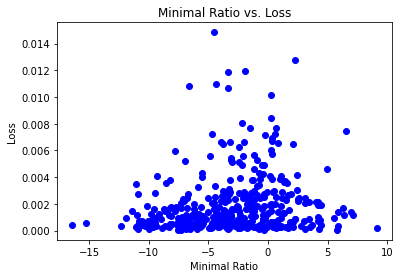

In [9]:
# plot results
plt.scatter(losses, minimal_ratios, c='blue')
plt.xlabel('Minimal Ratio')
plt.ylabel('Loss')
plt.title('Minimal Ratio vs. Loss')
plt.show()